In [3]:
import requests
import pandas as pd
import geopandas as gpd

import sys

sys.path.append("../")

# from helper_functions import *
# from loading_data import *
from Code.helper_functions import initial_loading
from Code.algorithms import random_start_hillclimber

POSTGRES password?WelkomCorne!


### Locations per cluster
The first step is to slightly modify the loading of the clusters

In [ ]:
def load_api_data(prnt=False):
    """
    This function loads in information on the current composition of container
    clusters in Amsterdam. It uses the API from data.amsterdam.nl (available at
    'https://api.data.amsterdam.nl/vsd/afvalclusters'). It returns the coordinates,
    amount and volume of different fractions and the address of the clusters. As
    a check, it is determined whether or not the cluster is currently active.
    Returns:
    - df containing coordinates, dict-like amount and volume per fraction and
    address.
    """
    x_coordinates = []
    y_coordinates = []
    aantal = []
    volumes = []
    adresses = []
    buurt = []

    link = 'https://api.data.amsterdam.nl/vsd/afvalclusters'

    while link != None: #This is the case on the last page of the API
        if prnt: # Can be used for some kind of monitoring of progres
            print(link)
        response = requests.get(link)
        output = response.json()
        for result in output['results']:
            if result['cluster_datum_einde_cluster'] == None: #Als het cluster nog actief is
                x_coordinates.append(str(result['cluster_geometrie']['coordinates'][0]))
                y_coordinates.append(str(result['cluster_geometrie']['coordinates'][1]))
                aantal.append(result['cluster_fractie_aantal'])
                volumes.append(result['cluster_fractie_volume'])
                adresses.append(result['bag_adres_openbare_ruimte_naam'])
                buurt.append(result['gbd_buurt_code'])
        try:
            link = output['_links']['next']['href'] #Retrieve link for next page
        except:
            link = None #True for last page of API

    df_clusters = pd.DataFrame([x_coordinates, y_coordinates, aantal, volumes, adresses, buurt]).T
    df_clusters = df_clusters.rename(columns={0: 'cluster_x', 1:'cluster_y', 2:'aantal_per_fractie', 3:'volume_per_fractie', 4: 'street_name', 5:'buurt'})
    # Transform coordinates of clusters to ints, as this helps easing join
    df_clusters['cluster_x'] = df_clusters['cluster_x'].astype('float').round(0).astype('int')
    df_clusters['cluster_y'] = df_clusters['cluster_y'].astype('float').round(0).astype('int')
    df_clusters['wijk'] = df_clusters['buurt'].str[:3]
    df_clusters['stadsdeel'] = df_clusters['buurt'].str[0]
    return df_clusters

In [ ]:
def load_geodata_containers(subsectie=None):
    """
    This function loads in all polygons representing areas in the city of Amsterdam
    where general waste needs to be brought to a container. This is different
    from the alternative where general waste is collected from the sidewalk. This
    is needed to filter the address POI's to relevant POI's for optimization.
    Subsectie is optional parameter to filter on specific stadsdelen. This can be used
    for partial optimization.

    Returns:
    - List of polygons making up the area of centralized garbage collection
    """

    source = gpd.read_file('../data/Inzameling_huisvuil_100220.shp')
    source = source[source['aanbiedwij'] == 'Breng uw restafval  naar een container voor restafval.']
    if subsectie:
        source = source[source['sdcode'] == subsectie]
    return list(source.geometry)

In [ ]:
def get_db_afvalcluster_info():
    """
    Function that modifies loads in data on the garbage clusters from the Postgres
    database and modifies the resulting dataframe in a way that makes it usable
    for future analysis
    Returns:
    - pandas DataFrame containing all information from the database and also the
    added coordinates for the clusters and the type of POI
    """
    polygon_list = load_geodata_containers()
    db_df = get_dataframe("""SELECT *
                             FROM proj_afval_netwerk.afv_rel_nodes_poi
                             """)
    db_df['woning'] = db_df['bk_afv_rel_nodes_poi'].str.split('~')
    db_df['cluster_x'] = db_df['woning'].apply(lambda x: x[0]).astype('float').round(0).astype('int')
    db_df['cluster_y'] = db_df['woning'].apply(lambda x: x[1]).astype('float').round(0).astype('int')
    db_df['type'] = db_df['woning'].apply(lambda x: x[2])
    db_df['bag'] = db_df['woning'].apply(lambda x: x[3])
    print('a')
#     db_df['uses_container'] = db_df.apply(lambda row: address_in_service_area(row['cluster_x'], row['cluster_y'], polygon_list = polygon_list), axis=1)
    db_df = db_df.drop('woning', axis=1)
    return db_df

In [ ]:
def create_all_households(rel_poi_df, subsectie=None):
    """
    Function that creates a dataframe containing all households as rows
    """
    polygon_list = load_geodata_containers(subsectie = subsectie)
    all_households = rel_poi_df[rel_poi_df['type']!='afval_cluster']
    all_households = all_households[['s1_afv_nodes', 'cluster_x', 'cluster_y']]
    print('b')
    all_households['uses_container'] = all_households.apply(lambda row: address_in_service_area(row['cluster_x'], row['cluster_y'], polygon_list=polygon_list), axis=1)
    return all_households

In [ ]:
df_clusters = load_api_data_neigborhood()

In [ ]:
df_clusters['stadsdeel'].value_counts()
# Stadsdeel Zuid-Oost (T) has 423 clusters. This is to be optimized

In [ ]:
rel_poi_df = get_db_afvalcluster_info()

In [ ]:
all_households = create_all_households(rel_poi_df, subsectie='T')

In [ ]:
joined = join_api_db(rel_poi_df, df_clusters)

In [ ]:
joined['rest'], joined['plastic'], joined['papier'], joined['glas'], joined['textiel'], joined['totaal'] = zip(*joined['aantal_per_fractie'].apply(lambda x: containers_per_cluster(x)))

In [ ]:
df_afstandn2 = distance_matrix_with_counts()

In [ ]:
for i in ['T', 'M', 'N', 'A', 'K', 'E', 'F', 'B']:
    print(i)
    all_households, rel_poi_df, joined, df_afstandn2 = initial_loading(use_count=True, subsectie=i)
    joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, penalties = \
    analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=True, use_count=True)

Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection?T
API data loaded
DB relation POIs loaded
Table all households created
API and DB joined
containers per cluster determined


..\Code\loading_data.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verblijfsobjecten['bag'] = verblijfsobjecten['split'].apply(lambda x: x[3]).astype('int64')


distance matrix loaded
How many random iterations?10
How many iterations hillclimber?20
Do you want the results saved(True/False)?True
Do you want to only use a subset of data?Ture
Do you want to use addresses instead of clusters?True
What parameter to optimize on (score/penalties)?penalties
Average distance is : 249.6004611676881
Penalties are: 308.1859662117452
Average distance is : 254.02442956940632
Penalties are: 319.9085892115329
Average distance is : 251.95626616743436
Penalties are: 320.9413878810317
Average distance is : 254.4581740794967
Penalties are: 335.33427856672427
Average distance is : 258.37575446499943
Penalties are: 325.6733294122486
Average distance is : 257.2809305525734
Penalties are: 340.44575707527764
Average distance is : 256.8267005819576
Penalties are: 334.76564096816645
Average distance is : 263.8342913062763
Penalties are: 336.82620506334325
Average distance is : 260.2847936184146
Penalties are: 324.4653209068839
Average distance is : 250.34930114917154
Pe

..\Code\algorithms.py:123: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = str(pd.datetime.now().date()) + '-' + str(pd.datetime.now().hour)


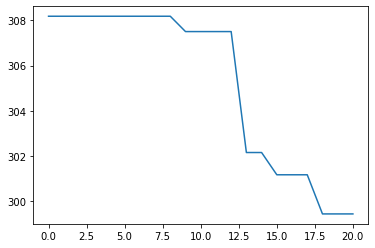

In [4]:
all_households, rel_poi_df, joined, df_afstandn2 = initial_loading()
hill_df, best_solution = random_start_hillclimber(joined, all_households, rel_poi_df, df_afstandn2)

How many random iterations?50
How many iterations hillclimber?1000
Do you want the results saved(True/False)?True
Do you want to only use a subset of data?True
Do you want to use addresses instead of clusters?True
What parameter to optimize on (score/penalties)?penalties
Average distance is : 249.6004611676881
Penalties are: 308.1859662117452
Average distance is : 256.8501165254244
Penalties are: 318.06544566692725
Average distance is : 257.65663841909384
Penalties are: 329.18789652972174
Average distance is : 264.42263133898905
Penalties are: 317.1555951048951
Average distance is : 264.0940907175675
Penalties are: 326.34529333251066
Average distance is : 256.91636230475126
Penalties are: 326.9116761959607
Average distance is : 268.52097579063326
Penalties are: 323.672936915984
Average distance is : 263.75628282235
Penalties are: 323.1913549865229
Average distance is : 267.1983497018804
Penalties are: 335.19606141505557
Average distance is : 256.12829477431114
Penalties are: 323.280846

Average distance is : 248.63553488963862
Penalties are: 292.8425774744738
292.8425774744738 292.0013859554074
Average distance is : 248.9748410755179
Penalties are: 293.66762521344384
293.66762521344384 292.0013859554074
Average distance is : 249.54374512978066
Penalties are: 293.42342471348195
293.42342471348195 292.0013859554074
Average distance is : 251.60572102673183
Penalties are: 301.66948209969155
301.66948209969155 292.0013859554074
Average distance is : 248.8175632619261
Penalties are: 290.9900570952281
290.9900570952281 292.0013859554074
Average distance is : 249.07060029157446
Penalties are: 295.62232320706755
295.62232320706755 290.9900570952281
Average distance is : 249.65514292138704
Penalties are: 296.4055692644301
296.4055692644301 290.9900570952281
Average distance is : 248.74502556089467
Penalties are: 291.5336877266096
291.5336877266096 290.9900570952281
Average distance is : 248.87034959159058
Penalties are: 289.4803264221713
289.4803264221713 290.9900570952281
Aver

Average distance is : 254.30885327007775
Penalties are: 290.5229784982082
290.5229784982082 283.1988482998583
Average distance is : 251.99246028050277
Penalties are: 282.211874843737
282.211874843737 283.1988482998583
Average distance is : 252.69785990720897
Penalties are: 281.5510479186633
281.5510479186633 282.211874843737
Average distance is : 252.22129016810777
Penalties are: 282.0171881745072
282.0171881745072 281.5510479186633
Average distance is : 253.57930129177527
Penalties are: 288.4951756739864
288.4951756739864 281.5510479186633
Average distance is : 253.2652672606855
Penalties are: 282.66680340847535
282.66680340847535 281.5510479186633
Average distance is : 252.70409995783803
Penalties are: 282.6106479228301
282.6106479228301 281.5510479186633
Average distance is : 259.74446928766884
Penalties are: 286.514014375599
286.514014375599 281.5510479186633
Average distance is : 253.59503712565515
Penalties are: 284.77274667694485
284.77274667694485 281.5510479186633
Average dist

Average distance is : 258.7716556664568
Penalties are: 277.2789302054252
277.2789302054252 276.3031237968248
Average distance is : 257.69290907463625
Penalties are: 276.90227201133376
276.90227201133376 276.3031237968248
Average distance is : 258.15149283245137
Penalties are: 280.7640168965374
280.7640168965374 276.3031237968248
Average distance is : 257.96004606591424
Penalties are: 278.70298772865533
278.70298772865533 276.3031237968248
Average distance is : 257.38182887331214
Penalties are: 278.3368280345014
278.3368280345014 276.3031237968248
Average distance is : 258.13887458616443
Penalties are: 279.84310910871284
279.84310910871284 276.3031237968248
Average distance is : 258.0337266821095
Penalties are: 279.5377505729405
279.5377505729405 276.3031237968248
Average distance is : 257.6532174099788
Penalties are: 281.4806045876911
281.4806045876911 276.3031237968248
Average distance is : 258.0591381263002
Penalties are: 277.9647732250677
277.9647732250677 276.3031237968248
Average 

Average distance is : 258.7494024399201
Penalties are: 276.2522355
276.2522355 274.1501347916667
Average distance is : 258.62711333541273
Penalties are: 273.68314085416665
273.68314085416665 274.1501347916667
Average distance is : 259.41071975188476
Penalties are: 275.6660572916666
275.6660572916666 273.68314085416665
Average distance is : 256.9074269803306
Penalties are: 273.27148218749994
273.27148218749994 273.68314085416665
Average distance is : 256.4569720096419
Penalties are: 280.78423116666664
280.78423116666664 273.27148218749994
Average distance is : 258.2471336053052
Penalties are: 275.3552250625
275.3552250625 273.27148218749994
Average distance is : 257.8520222955205
Penalties are: 277.59360920833336
277.59360920833336 273.27148218749994
Average distance is : 257.7205176590025
Penalties are: 273.29456216666665
273.29456216666665 273.27148218749994
Average distance is : 257.6344136046333
Penalties are: 274.2899302083333
274.2899302083333 273.27148218749994
Average distance i

Average distance is : 259.7450083640449
Penalties are: 270.6164645833333
270.6164645833333 268.97985777083335
Average distance is : 259.54914020717035
Penalties are: 268.5505714375
268.5505714375 268.97985777083335
Average distance is : 260.52334405555774
Penalties are: 267.81581695833336
267.81581695833336 268.5505714375
Average distance is : 260.59563789792844
Penalties are: 271.30165418750005
271.30165418750005 267.81581695833336
Average distance is : 261.74168765256405
Penalties are: 271.96936554166666
271.96936554166666 267.81581695833336
Average distance is : 260.6862204915602
Penalties are: 269.18113864583336
269.18113864583336 267.81581695833336
Average distance is : 260.76430584014247
Penalties are: 268.0332639791667
268.0332639791667 267.81581695833336
Average distance is : 258.74802942573035
Penalties are: 270.0211746041667
270.0211746041667 267.81581695833336
Average distance is : 259.7009983709444
Penalties are: 270.42978345833336
270.42978345833336 267.81581695833336
Aver

Average distance is : 263.3602748029806
Penalties are: 264.5248959418358
264.5248959418358 259.0820403316529
Average distance is : 266.65392222234726
Penalties are: 260.093118953377
260.093118953377 259.0820403316529
Average distance is : 264.3074948164541
Penalties are: 260.8381931169535
260.8381931169535 259.0820403316529
Average distance is : 263.98547806671235
Penalties are: 261.3441329319612
261.3441329319612 259.0820403316529
Average distance is : 262.8244641141216
Penalties are: 263.4867853628282
263.4867853628282 259.0820403316529
Average distance is : 263.78138667083607
Penalties are: 259.2406804508146
259.2406804508146 259.0820403316529
Average distance is : 263.97645920214757
Penalties are: 259.70803899837506
259.70803899837506 259.0820403316529
Average distance is : 263.8996049383839
Penalties are: 263.7098680471647
263.7098680471647 259.0820403316529
Average distance is : 263.74483460317475
Penalties are: 262.7543984833966
262.7543984833966 259.0820403316529
Average distan

Average distance is : 263.4596452383818
Penalties are: 248.97852129077955
248.97852129077955 248.5099205241448
Average distance is : 263.50568988986737
Penalties are: 250.29688219240865
250.29688219240865 248.5099205241448
Average distance is : 263.9189316737135
Penalties are: 253.48209522519895
253.48209522519895 248.5099205241448
Average distance is : 264.0076596447885
Penalties are: 253.8362311778676
253.8362311778676 248.5099205241448
Average distance is : 263.4256363638579
Penalties are: 251.76426198808483
251.76426198808483 248.5099205241448
Average distance is : 263.1388490898432
Penalties are: 252.92911820105383
252.92911820105383 248.5099205241448
Average distance is : 263.2174522698385
Penalties are: 252.85364116078497
252.85364116078497 248.5099205241448
Average distance is : 263.9614969474589
Penalties are: 249.62770663722344
249.62770663722344 248.5099205241448
Average distance is : 263.8461375023272
Penalties are: 249.10731000791634
249.10731000791634 248.5099205241448
Av

Average distance is : 262.241168385848
Penalties are: 246.9212905
246.9212905 246.15932425000003
Average distance is : 262.6912296843703
Penalties are: 248.9150272916667
248.9150272916667 246.15932425000003
Average distance is : 262.9431393595995
Penalties are: 247.62567697916668
247.62567697916668 246.15932425000003
Average distance is : 264.2432085593881
Penalties are: 247.15374731249997
247.15374731249997 246.15932425000003
Average distance is : 263.3587797612819
Penalties are: 253.38488683333335
253.38488683333335 246.15932425000003
Average distance is : 265.74403286090137
Penalties are: 250.61149139583335
250.61149139583335 246.15932425000003
Average distance is : 260.7628654860003
Penalties are: 251.87371248334446
251.87371248334446 246.15932425000003
Average distance is : 263.08436277871823
Penalties are: 246.34468404166668
246.34468404166668 246.15932425000003
Average distance is : 260.53416204625023
Penalties are: 250.76599152083335
250.76599152083335 246.15932425000003
Averag

Average distance is : 262.8523541101744
Penalties are: 247.39148954253812
247.39148954253812 243.04821989834184
Average distance is : 262.9985128559841
Penalties are: 244.1100545371219
244.1100545371219 243.04821989834184
Average distance is : 263.4259166444581
Penalties are: 247.71377591450712
247.71377591450712 243.04821989834184
Average distance is : 264.6625411343846
Penalties are: 247.66003066411133
247.66003066411133 243.04821989834184
Average distance is : 262.91367085605833
Penalties are: 245.47127797683527
245.47127797683527 243.04821989834184
Average distance is : 262.5327613813866
Penalties are: 243.63724695858681
243.63724695858681 243.04821989834184
Average distance is : 262.8037152693899
Penalties are: 243.47806949420882
243.47806949420882 243.04821989834184
Average distance is : 261.91308997153845
Penalties are: 246.09344312973917
246.09344312973917 243.04821989834184
Average distance is : 262.82733888633
Penalties are: 243.17892931839015
243.17892931839015 243.048219898

Average distance is : 262.55258208356474
Penalties are: 246.912665968304
246.912665968304 241.02611201149904
Average distance is : 262.0462617845821
Penalties are: 241.49090898675112
241.49090898675112 241.02611201149904
Average distance is : 262.30985190360235
Penalties are: 242.7976227606033
242.7976227606033 241.02611201149904
Average distance is : 263.942540705032
Penalties are: 241.15717446462793
241.15717446462793 241.02611201149904
Average distance is : 262.1741173003409
Penalties are: 243.93617675610366
243.93617675610366 241.02611201149904
Average distance is : 261.8991801087948
Penalties are: 242.05785565786186
242.05785565786186 241.02611201149904
Average distance is : 261.68411677660436
Penalties are: 244.3775563019305
244.3775563019305 241.02611201149904
Average distance is : 261.67995438290717
Penalties are: 244.20145324707534
244.20145324707534 241.02611201149904
Average distance is : 262.9111135282479
Penalties are: 243.56857128572616
243.56857128572616 241.026112011499

Average distance is : 261.30550563089304
Penalties are: 248.04388413465543
248.04388413465543 240.48134009665858
Average distance is : 261.7144964574533
Penalties are: 246.05258678443462
246.05258678443462 240.48134009665858
Average distance is : 262.24515069057634
Penalties are: 241.66438567619366
241.66438567619366 240.48134009665858
Average distance is : 261.81191142600653
Penalties are: 239.56488642613115
239.56488642613115 240.48134009665858
Average distance is : 261.62866625666663
Penalties are: 241.1106082201483
241.1106082201483 239.56488642613115
Average distance is : 262.1010388938015
Penalties are: 240.0340632655612
240.0340632655612 239.56488642613115
Average distance is : 261.27069302167286
Penalties are: 240.43948108490957
240.43948108490957 239.56488642613115
Average distance is : 262.6766450546341
Penalties are: 241.7347463336388
241.7347463336388 239.56488642613115
Average distance is : 262.3969987988493
Penalties are: 244.38857984751266
244.38857984751266 239.56488642

Average distance is : 263.15473112952276
Penalties are: 239.52634806698882
239.52634806698882 236.22510304532577
Average distance is : 262.4944510565038
Penalties are: 238.25585339943345
238.25585339943345 236.22510304532577
Average distance is : 262.1158140520903
Penalties are: 236.22559662972836
236.22559662972836 236.22510304532577
Average distance is : 257.2706716493099
Penalties are: 253.1762440634894
253.1762440634894 236.22510304532577
Average distance is : 263.59917915507896
Penalties are: 241.5754430094984
241.5754430094984 236.22510304532577
Average distance is : 257.23536347294356
Penalties are: 247.50100839443428
247.50100839443428 236.22510304532577
Average distance is : 261.5561804307649
Penalties are: 238.11634148475252
238.11634148475252 236.22510304532577
Average distance is : 260.90651277964866
Penalties are: 238.58112440131606
238.58112440131606 236.22510304532577
Average distance is : 262.2036528951106
Penalties are: 237.7990289743376
237.7990289743376 236.225103045

Average distance is : 262.7557920616411
Penalties are: 245.56960930847765
245.56960930847765 234.97521126525848
Average distance is : 262.1495591945195
Penalties are: 237.01124853143358
237.01124853143358 234.97521126525848
Average distance is : 262.2410037023293
Penalties are: 237.38351970669112
237.38351970669112 234.97521126525848
Average distance is : 261.54327756319947
Penalties are: 237.9554443703642
237.9554443703642 234.97521126525848
Average distance is : 260.1280615512291
Penalties are: 238.6911774361538
238.6911774361538 234.97521126525848
Average distance is : 261.7079674173727
Penalties are: 237.44757255343077
237.44757255343077 234.97521126525848
Average distance is : 258.5501546451852
Penalties are: 251.68693746615006
251.68693746615006 234.97521126525848
Average distance is : 258.33602949285444
Penalties are: 245.73117668624752
245.73117668624752 234.97521126525848
Average distance is : 262.59821600459895
Penalties are: 237.67267012456776
237.67267012456776 234.97521126

..\Code\algorithms.py:123: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = str(pd.datetime.now().date()) + '-' + str(pd.datetime.now().hour)


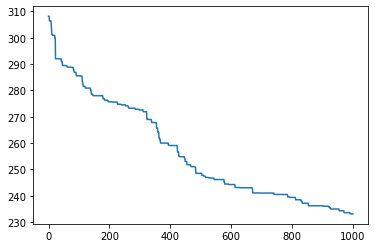

In [5]:
hill_df, best_solution = random_start_hillclimber(joined, all_households, rel_poi_df, df_afstandn2)

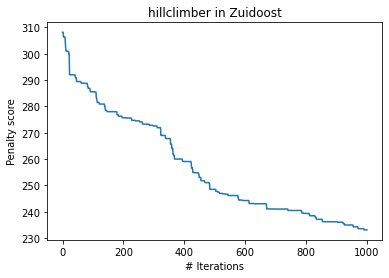

In [14]:
plt = hill_df['best'].plot(title='hillclimber in Zuidoost')
plt.set_xlabel('# Iterations')
plt.set_ylabel('Penalty score')
plt.figure.savefig('20200430-hillclimber_zuidoost.pdf')